# Programming Assignment: 
## Готовим LDA по рецептам

Как вы уже знаете, в тематическом моделировании делается предположение о том, что для определения тематики порядок слов в документе не важен; об этом гласит гипотеза «мешка слов». Сегодня мы будем работать с несколько нестандартной для тематического моделирования коллекцией, которую можно назвать «мешком ингредиентов», потому что она состоит из рецептов блюд разных кухонь. Тематические модели ищут слова, которые часто вместе встречаются в документах, и составляют из них темы. Мы попробуем применить эту идею к рецептам и найти кулинарные «темы». Эта коллекция хороша тем, что не требует предобработки. Кроме того, эта задача достаточно наглядно иллюстрирует принцип работы тематических моделей.

Для выполнения заданий, помимо часто используемых в курсе библиотек, потребуются модули *json* и *gensim*. Первый входит в дистрибутив Anaconda, второй можно поставить командой 

*pip install gensim*

Построение модели занимает некоторое время. На ноутбуке с процессором Intel Core i7 и тактовой частотой 2400 МГц на построение одной модели уходит менее 10 минут.

### Загрузка данных

Коллекция дана в json-формате: для каждого рецепта известны его id, кухня (cuisine) и список ингредиентов, в него входящих. Загрузить данные можно с помощью модуля json (он входит в дистрибутив Anaconda):

In [1]:
import json

In [2]:
with open("data/07_recipes.json") as f:
    recipes = json.load(f)

In [3]:
print recipes[0]

{u'cuisine': u'greek', u'id': 10259, u'ingredients': [u'romaine lettuce', u'black olives', u'grape tomatoes', u'garlic', u'pepper', u'purple onion', u'seasoning', u'garbanzo beans', u'feta cheese crumbles']}


### Составление корпуса

In [4]:
from gensim import corpora, models
import numpy as np

C:\Anaconda3\envs\mlda_compatible\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Наша коллекция небольшая, и целиком помещается в оперативную память. Gensim может работать с такими данными и не требует их сохранения на диск в специальном формате. Для этого коллекция должна быть представлена в виде списка списков, каждый внутренний список соответствует отдельному документу и состоит из его слов. Пример коллекции из двух документов: 

[["hello", "world"], ["programming", "in", "python"]]

Преобразуем наши данные в такой формат, а затем создадим объекты corpus и dictionary, с которыми будет работать модель.

In [5]:
texts = [recipe["ingredients"] for recipe in recipes]
dictionary = corpora.Dictionary(texts)   # составляем словарь
corpus = [dictionary.doc2bow(text) for text in texts]  # составляем корпус документов

In [6]:
print texts[0]
print corpus[0]

[u'romaine lettuce', u'black olives', u'grape tomatoes', u'garlic', u'pepper', u'purple onion', u'seasoning', u'garbanzo beans', u'feta cheese crumbles']
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]


У объекта dictionary есть полезная переменная dictionary.token2id, позволяющая находить соответствие между ингредиентами и их индексами.

### Обучение модели
Вам может понадобиться [документация](https://radimrehurek.com/gensim/models/ldamodel.html) LDA в gensim.

__Задание 1.__ Обучите модель LDA с 40 темами, установив количество проходов по коллекции 5 и оставив остальные параметры по умолчанию. 


Затем вызовите метод модели *show_topics*, указав количество тем 40 и количество токенов 10, и сохраните результат (топы ингредиентов в темах) в отдельную переменную. Если при вызове метода *show_topics* указать параметр *formatted=True*, то топы ингредиентов будет удобно выводить на печать, если *formatted=False*, будет удобно работать со списком программно. Выведите топы на печать, рассмотрите темы, а затем ответьте на вопрос:

Сколько раз ингредиенты "salt", "sugar", "water", "mushrooms", "chicken", "eggs" встретились среди топов-10 всех 40 тем? При ответе __не нужно__ учитывать составные ингредиенты, например, "hot water".

Передайте 6 чисел в функцию save_answers1 и загрузите сгенерированный файл в форму.

У gensim нет возможности фиксировать случайное приближение через параметры метода, но библиотека использует numpy для инициализации матриц. Поэтому, по утверждению автора библиотеки, фиксировать случайное приближение нужно командой, которая написана в следующей ячейке. __Перед строкой кода с построением модели обязательно вставляйте указанную строку фиксации random.seed.__

In [7]:
np.random.seed(76543)

# здесь код для построения модели:
%time ldamodel = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=40, passes=5)

Wall time: 2min 11s


In [8]:
top_ingredients = ldamodel.show_topics(num_topics=40, num_words=10, formatted=False)
print ldamodel.show_topics(num_topics=40, num_words=10, formatted=True)[0]

(0, u'0.083*"salt" + 0.080*"cooking spray" + 0.079*"garlic cloves" + 0.064*"olive oil" + 0.064*"chopped onion" + 0.035*"fat free less sodium chicken broth" + 0.034*"crushed red pepper" + 0.034*"water" + 0.033*"black pepper" + 0.032*"ground black pepper"')


In [9]:
top_ingredients[0][1][2]

(u'garlic cloves', 0.07949757742152684)

In [10]:
from collections import Counter
ingredients = ["salt", "sugar", "water", "mushrooms", "chicken", "eggs"]

occurrences = [
    ingr
    for _, topic_top in top_ingredients
    for topic_ingr, prob in topic_top
    for ingr in ingredients
    if ingr == topic_ingr
]

counter = Counter(occurrences)
result = [counter[ingr] for ingr in ingredients]
print counter
print result

Counter({'salt': 20, 'water': 10, 'sugar': 7, 'eggs': 2, 'mushrooms': 1, 'chicken': 1})
[20, 7, 10, 1, 1, 2]


In [11]:
def save_answers1(c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs):
    with open("out/07_cooking_lda_pa_01.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [c_salt, c_sugar, c_water, c_mushrooms, c_chicken, c_eggs]]))
        
save_answers1(*result)

### Фильтрация словаря
В топах тем гораздо чаще встречаются первые три рассмотренных ингредиента, чем последние три. При этом наличие в рецепте курицы, яиц и грибов яснее дает понять, что мы будем готовить, чем наличие соли, сахара и воды. Таким образом, даже в рецептах есть слова, часто встречающиеся в текстах и не несущие смысловой нагрузки, и поэтому их не желательно видеть в темах. Наиболее простой прием борьбы с такими фоновыми элементами — фильтрация словаря по частоте. Обычно словарь фильтруют с двух сторон: убирают очень редкие слова (в целях экономии памяти) и очень частые слова (в целях повышения интерпретируемости тем). Мы уберем только частые слова.

In [12]:
import copy
dictionary2 = copy.deepcopy(dictionary)

__Задание 2.__ У объекта dictionary2 есть переменная *dfs* — это словарь, ключами которого являются id токена, а элементами — число раз, сколько слово встретилось во всей коллекции. Сохраните в отдельный список ингредиенты, которые встретились в коллекции больше 4000 раз. Вызовите метод словаря *filter_tokens*, подав в качестве первого аргумента полученный список популярных ингредиентов. Вычислите две величины: dict_size_before и dict_size_after — размер словаря до и после фильтрации.

Затем, используя новый словарь, создайте новый корпус документов, corpus2, по аналогии с тем, как это сделано в начале ноутбука. Вычислите две величины: corpus_size_before и corpus_size_after — суммарное количество ингредиентов в корпусе (для каждого документа вычислите число различных ингредиентов в нем и просуммируйте по всем документам) до и после фильтрации.

Передайте величины dict_size_before, dict_size_after, corpus_size_before, corpus_size_after в функцию save_answers2 и загрузите сгенерированный файл в форму.

In [13]:
freq_ingredients = [token_id for token_id, occur in dictionary2.dfs.items() if occur > 4000]
print len(freq_ingredients)

12


In [14]:
removed_ingr = [dictionary.id2token[ingr] for ingr in freq_ingredients]

In [15]:
dict_size_before = len(dictionary)
print dict_size_before

dictionary2.filter_tokens(bad_ids=freq_ingredients)
dict_size_after = len(dictionary2)
print dict_size_after

6714
6702


In [16]:
corpus2 = [dictionary2.doc2bow(text) for text in texts]

print texts[0]
print corpus2[0]

[u'romaine lettuce', u'black olives', u'grape tomatoes', u'garlic', u'pepper', u'purple onion', u'seasoning', u'garbanzo beans', u'feta cheese crumbles']
[(1880, 1), (2837, 1), (3225, 1), (3714, 1), (4902, 1), (5729, 1), (6110, 1)]


In [17]:
def count_corpus_size(corpus):
    return sum([len(recipe) for recipe in corpus])

corpus_size_before = count_corpus_size(corpus)
corpus_size_after = count_corpus_size(corpus2)

In [18]:
def save_answers2(dict_size_before, dict_size_after, corpus_size_before, corpus_size_after):
    with open("out/07_cooking_lda_pa_02.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [dict_size_before, dict_size_after, corpus_size_before, corpus_size_after]]))
        
save_answers2(dict_size_before, dict_size_after, corpus_size_before, corpus_size_after)

### Сравнение когерентностей
__Задание 3.__ Постройте еще одну модель по корпусу corpus2 и словарю dictionary2, остальные параметры оставьте такими же, как при первом построении модели. Сохраните новую модель в другую переменную (не перезаписывайте предыдущую модель). Не забудьте про фиксирование seed!

Затем воспользуйтесь методом *top_topics* модели, чтобы вычислить ее когерентность. Передайте в качестве аргумента соответствующий модели корпус. Метод вернет список кортежей (топ токенов, когерентность), отсортированных по убыванию последней. Вычислите среднюю по всем темам когерентность для каждой из двух моделей и передайте в функцию save_answers3. 

In [19]:
np.random.seed(76543)

# здесь код для построения модели:
%time ldamodel2 = models.ldamodel.LdaModel(corpus=corpus2, id2word=dictionary2, num_topics=40, passes=5)

Wall time: 2min 5s


In [20]:
coherence = ldamodel.top_topics(corpus)
coherence2 = ldamodel2.top_topics(corpus2)
print coherence2[2]

([(0.07857400528185235, u'rice vinegar'), (0.07165901935490478, u'soy sauce'), (0.06429940989048159, u'scallions'), (0.052859351839580515, u'sesame seeds'), (0.05162108793848416, u'sesame oil'), (0.04213485439829214, u'honey'), (0.03678515208740983, u'fresh ginger'), (0.035191731243686734, u'green onions'), (0.03275133209733739, u'low sodium soy sauce'), (0.02456105020320966, u'carrots'), (0.023776089694191885, u'toasted sesame seeds'), (0.022070383660104404, u'Sriracha'), (0.02190714339700814, u'ground white pepper'), (0.021227517016355505, u'toasted sesame oil'), (0.019657237941706658, u'peeled fresh ginger'), (0.019359082942238762, u'canola oil'), (0.017678874667507997, u'corn starch'), (0.017158311463598717, u'kosher salt'), (0.01620823922432056, u'brown sugar'), (0.016179839967652397, u'flank steak')], -533.4275355132789)


In [21]:
np.array([coh for _, coh in coherence])

array([-437.94129331, -452.34106674, -474.53187092, -474.87064695,
       -487.19414209, -524.78811123, -526.73995313, -539.50125378,
       -547.59205214, -558.66855629, -568.34863836, -576.8558833 ,
       -583.63008627, -601.77919312, -603.83206049, -633.07840874,
       -647.13620546, -670.8568372 , -676.31239619, -693.22912025,
       -703.51949876, -738.22838143, -742.22881507, -747.10109283,
       -779.78885207, -796.43628481, -803.57910946, -815.39923606,
       -832.80063704, -856.81998808, -863.39841078, -872.23052665,
       -874.83684025, -879.69064474, -886.44976626, -887.814724  ,
       -890.23390064, -903.92865245, -912.1381563 , -912.38766519])

In [22]:
def get_avg_coherence(coherence):
    return np.mean(np.array([coh for _, coh in coherence]))
    
avg_coherence = get_avg_coherence(coherence)
avg_coherence2 = get_avg_coherence(coherence2)

In [23]:
def save_answers3(coherence, coherence2):
    with open("out/07_cooking_lda_pa_03.txt", "w") as fout:
        fout.write(" ".join(["%3f"%el for el in [coherence, coherence2]]))
        
save_answers3(avg_coherence, avg_coherence2)

Считается, что когерентность хорошо соотносится с человеческими оценками интерпретируемости тем. Поэтому на больших текстовых коллекциях когерентность обычно повышается, если убрать фоновую лексику. Однако в нашем случае этого не произошло. 

### Изучение влияния гиперпараметра alpha

В этом разделе мы будем работать со второй моделью, то есть той, которая построена по сокращенному корпусу. 

Пока что мы посмотрели только на матрицу темы-слова, теперь давайте посмотрим на матрицу темы-документы. Выведите темы для нулевого (или любого другого) документа из корпуса, воспользовавшись методом *get_document_topics* второй модели:

In [24]:
texts[:1]

[[u'romaine lettuce',
  u'black olives',
  u'grape tomatoes',
  u'garlic',
  u'pepper',
  u'purple onion',
  u'seasoning',
  u'garbanzo beans',
  u'feta cheese crumbles']]

In [25]:
list(ldamodel2.get_document_topics(corpus2[:3]))

[[(5, 0.13075189526717995),
  (7, 0.5051466841643809),
  (11, 0.24847642056843797)],
 [(19, 0.29848873965895434),
  (24, 0.3134561727020889),
  (29, 0.1596052856341634),
  (31, 0.12844980200479283)],
 [(15, 0.10249999999999995),
  (25, 0.4096727900171727),
  (31, 0.18349872936829517),
  (34, 0.21432848061453186)]]

Также выведите содержимое переменной *.alpha* второй модели:

In [26]:
ldamodel2.alpha

array([0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
       0.025, 0.025, 0.025, 0.025])

У вас должно получиться, что документ характеризуется небольшим числом тем. Попробуем поменять гиперпараметр alpha, задающий априорное распределение Дирихле для распределений тем в документах.

__Задание 4.__ Обучите третью модель: используйте сокращенный корпус (corpus2 и dictionary2) и установите параметр __alpha=1__, passes=5. Не забудьте про фиксацию seed! Выведите темы новой модели для нулевого документа; должно получиться, что распределение над множеством тем практически равномерное. Чтобы убедиться в том, что во второй модели документы описываются гораздо более разреженными распределениями, чем в третьей, посчитайте суммарное количество элементов, __превосходящих 0.01__, в матрицах темы-документы обеих моделей. Другими словами, запросите темы  модели для каждого документа с параметром *minimum_probability=0.01* и просуммируйте число элементов в получаемых массивах. Передайте две суммы (сначала для модели с alpha по умолчанию, затем для модели в alpha=1) в функцию save_answers4.

In [27]:
np.random.seed(76543)

# здесь код для построения модели:
%time ldamodel3 = models.ldamodel.LdaModel(corpus=corpus2, id2word=dictionary2, num_topics=40, passes=5, alpha=1)

Wall time: 1min 37s


In [28]:
list(ldamodel3.get_document_topics(corpus2[0]))[:5]

[(0, 0.02127962940370775),
 (1, 0.02127659574468166),
 (2, 0.021286183136532917),
 (3, 0.022008930955540008),
 (4, 0.02127659574468085)]

In [29]:
def get_document_topics_count(model, corpus, min_prob=0.01):
    probs = model.get_document_topics(corpus, minimum_probability=min_prob)
    return sum([len(lst) for lst in probs])

In [30]:
def save_answers4(count_model2, count_model3):
    with open("out/07_cooking_lda_pa_04.txt", "w") as fout:
        fout.write(" ".join([str(el) for el in [count_model2, count_model3]]))
        
save_answers4(
    get_document_topics_count(ldamodel2, corpus2),
    get_document_topics_count(ldamodel3, corpus2)
)

Таким образом, гиперпараметр __alpha__ влияет на разреженность распределений тем в документах. Аналогично гиперпараметр __eta__ влияет на разреженность распределений слов в темах.

### LDA как способ понижения размерности
Иногда, распределения над темами, найденные с помощью LDA, добавляют в матрицу объекты-признаки как дополнительные, семантические, признаки, и это может улучшить качество решения задачи. Для простоты давайте просто обучим классификатор рецептов на кухни на признаках, полученных из LDA, и измерим точность (accuracy).

__Задание 5.__ Используйте модель, построенную по сокращенной выборке с alpha по умолчанию (вторую модель). Составьте матрицу $\Theta = p(t|d)$ вероятностей тем в документах; вы можете использовать тот же метод get_document_topics, а также вектор правильных ответов y (в том же порядке, в котором рецепты идут в переменной recipes). Создайте объект RandomForestClassifier со 100 деревьями, с помощью функции cross_val_score вычислите среднюю accuracy по трем фолдам (перемешивать данные не нужно) и передайте в функцию save_answers5.

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [32]:
doc_topics = ldamodel2.get_document_topics(corpus2)

In [33]:
len(corpus2)

39774

In [34]:
np.tile(3, 4)

array([3, 3, 3, 3])

In [35]:
ndocs = len(corpus2)

i = [None] * ndocs
j = [None] * ndocs
d = [None] * ndocs

for ind, doc in enumerate(doc_topics):
    i[ind] = [ind] * len(doc)
    j[ind] = [jj for jj, _ in doc]
    d[ind] = [prob for _, prob in doc]
    
i = np.hstack(i)
j = np.hstack(j)
d = np.hstack(d)

In [36]:
for ind in range(5):
    print i[ind], j[ind], d[ind]

0 5 0.13075685312853644
0 7 0.5054671186131685
0 11 0.24815102825829388
1 19 0.2984834336085862
1 24 0.31345177865861407


In [37]:
from scipy.sparse import coo_matrix

X = coo_matrix((d, (i, j)))

In [38]:
cuisines = {r['cuisine'] for r in recipes}
cuisine2id = {c:i for i, c in enumerate(cuisines)}
id2cuisine = {v:k for k, v in cuisine2id.items()}

print cuisine2id

{u'irish': 0, u'mexican': 1, u'chinese': 2, u'filipino': 3, u'vietnamese': 4, u'spanish': 13, u'japanese': 7, u'moroccan': 5, u'french': 12, u'greek': 9, u'indian': 10, u'jamaican': 11, u'british': 8, u'brazilian': 6, u'russian': 14, u'cajun_creole': 15, u'thai': 16, u'southern_us': 17, u'korean': 18, u'italian': 19}


In [39]:
y = [cuisine2id[r['cuisine']] for r in recipes]
y[:10]

[9, 17, 3, 10, 10, 11, 13, 19, 1, 19]

In [40]:
rfclass = RandomForestClassifier(n_estimators=100)
%time result = cross_val_score(rfclass, X, y, cv=3, n_jobs=3, error_score='accuracy')

Wall time: 1min 20s


In [41]:
result

array([0.55537963, 0.55743269, 0.56285844])

In [42]:
def save_answers5(accuracy):
     with open("out/07_cooking_lda_pa_05.txt", "w") as fout:
        fout.write(str(accuracy))

save_answers5(result.mean())

Для такого большого количества классов это неплохая точность. Вы можете попроовать обучать RandomForest на исходной матрице частот слов, имеющей значительно большую размерность, и увидеть, что accuracy увеличивается на 10–15%. Таким образом, LDA собрал не всю, но достаточно большую часть информации из выборки, в матрице низкого ранга.

### LDA — вероятностная модель
Матричное разложение, использующееся в LDA, интерпретируется как следующий процесс генерации документов.

Для документа $d$ длины $n_d$:
1. Из априорного распределения Дирихле с параметром alpha сгенерировать распределение над множеством тем: $\theta_d \sim Dirichlet(\alpha)$
1. Для каждого слова $w = 1, \dots, n_d$:
    1. Сгенерировать тему из дискретного распределения $t \sim \theta_{d}$
    1. Сгенерировать слово из дискретного распределения $w \sim \phi_{t}$.
    
Подробнее об этом в [Википедии](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

В контексте нашей задачи получается, что, используя данный генеративный процесс, можно создавать новые рецепты. Вы можете передать в функцию модель и число ингредиентов и сгенерировать рецепт :)

In [44]:
def generate_recipe(model, num_ingredients):
    theta = np.random.dirichlet(model.alpha)
    for i in range(num_ingredients):
        t = np.random.choice(np.arange(model.num_topics), p=theta)
        topic = model.show_topic(t, topn=model.num_terms)
        topic_distr = [x[1] for x in topic]
        terms = [x[0] for x in topic]
        w = np.random.choice(terms, p=topic_distr)
        print w

In [47]:
generate_recipe(ldamodel2, 10)

boneless skinless chicken breasts
tomato paste
breakfast sausages
red chili powder
onion powder
dried oregano
garlic powder
oregano
dried oregano
zucchini


### Интерпретация построенной модели
Вы можете рассмотреть топы ингредиентов каждой темы. Большиснтво тем сами по себе похожи на рецепты; в некоторых собираются продукты одного вида, например, свежие фрукты или разные виды сыра.

Попробуем эмпирически соотнести наши темы с национальными кухнями (cuisine). Построим матрицу $A$ размера темы $x$ кухни, ее элементы $a_{tc}$ — суммы $p(t|d)$ по всем документам $d$, которые отнесены к кухне $c$. Нормируем матрицу на частоты рецептов по разным кухням, чтобы избежать дисбаланса между кухнями. Следующая функция получает на вход объект модели, объект корпуса и исходные данные и возвращает нормированную матрицу $A$. Ее удобно визуализировать с помощью seaborn.

In [48]:
import pandas
import seaborn
from matplotlib import pyplot as plt
%matplotlib inline

In [49]:
def compute_topic_cuisine_matrix(model, corpus, recipes):
    # составляем вектор целевых признаков
    targets = list(set([recipe["cuisine"] for recipe in recipes]))
    # составляем матрицу
    tc_matrix = pandas.DataFrame(data=np.zeros((model.num_topics, len(targets))), columns=targets)
    for recipe, bow in zip(recipes, corpus):
        recipe_topic = model.get_document_topics(bow)
        for t, prob in recipe_topic:
            tc_matrix[recipe["cuisine"]][t] += prob
    # нормируем матрицу
    target_sums = pandas.DataFrame(data=np.zeros((1, len(targets))), columns=targets)
    for recipe in recipes:
        target_sums[recipe["cuisine"]] += 1
    return pandas.DataFrame(tc_matrix.values/target_sums.values, columns=tc_matrix.columns)

In [50]:
def plot_matrix(tc_matrix):
    plt.figure(figsize=(10, 10))
    seaborn.heatmap(tc_matrix, square=True)

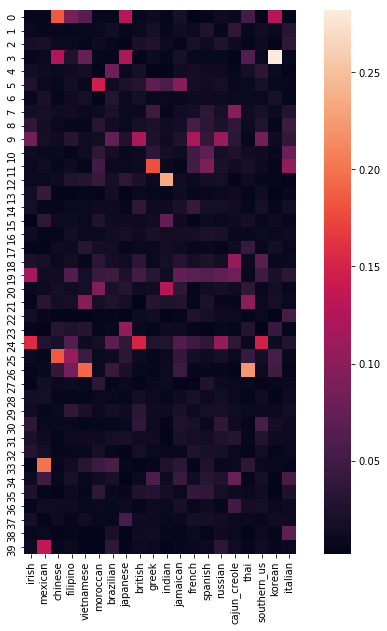

In [51]:
# Визуализируйте матрицу
plot_matrix(compute_topic_cuisine_matrix(ldamodel2, corpus2, recipes))

Чем темнее квадрат в матрице, тем больше связь этой темы с данной кухней. Мы видим, что у нас есть темы, которые связаны с несколькими кухнями. Такие темы показывают набор ингредиентов, которые популярны в кухнях нескольких народов, то есть указывают на схожесть кухонь этих народов. Некоторые темы распределены по всем кухням равномерно, они показывают наборы продуктов, которые часто используются в кулинарии всех стран. 

Жаль, что в датасете нет названий рецептов, иначе темы было бы проще интерпретировать...

### Заключение
В этом задании вы построили несколько моделей LDA, посмотрели, на что влияют гиперпараметры модели и как можно использовать построенную модель. 